# 1. セマンティックセグメンテーションとは
セマンティックセグメンテーションは画像認識タスクの1つである。本章ではセマンティックセグメンテーションに取り組みながら、**PSPNet**(Pyramid Scene Parsing Network)と呼ばれるディープランニングモデルについて学ぶ。

本章の学習目標
1. セマンティックセグメンテーションとは、何をインプットに何をアウトプットにしている画像処理タスクなのかを理解する
2. カラーパレット形式の画像データについて理解する
3. PSPNetによるセマンティックセグメンテーションの4Stepの流れを理解する

## セマンティックセグメンテーションの概要
1枚の画像中に含まれる複数の物体に対して、物体の領域と名前を、<u>ピクセルレベルで付与する</u>タスクである
第2章の物体検出では物体を大きく長方形のバウンディングボックスで囲んだが、セマンティックセグメンテーションでは
ピクセルレベルで「どこからどこまでがラベルなのか」をラベル付けする

セマンティックセグメンテーションは
- 製造業における製品の傷部位の検出
- 医療画像診断における病変部分の検出
- 自動運転技術における周囲の環境把握
などに使われる

## セマンティックセグメンテーションの入出力
    入力：画像
    出力：各ピクセルが所属するクラスのラベル情報
例えば、<u>入力画像のサイズが縦300×横500</u>とすると分類したい物体のクラス数が21種類であるとする。このときの出力は___各要素が物体のクラスを示すインデックス値0~20の300×500の配列___となる。

In [3]:
import torch
import warnings
warnings.simplefilter('ignore')

In [4]:
import cv2

## PSPNetによる物体検出の流れ
物体検出は以下の4ステップとなる。
1. 前処理として画像の大きさを`input_size` × `input_size`ピクセルサイズにリサイズする。本書では`input_size = 475`とする。
2. PSPNetのニューラルネットワークに前処理した画像を入力する。出力として21×475×475の配列が出力される。各ピクセルが各クラスである確信度を表す。
3. PSPNetの出力値に対してピクセルごとに確信度の最大のクラスを求め、各ピクセルが対応すると予想されたクラスを求める。このピクセルごとの確信度最大クラスの情報がPSPNetの出力となる。
4. セマンティックセグメンテーションの出力をもとの入力画像の大きさにリサイズする

# 2. DatasetとDataLoaderの実装
セマンティックセグメンテーション用のDataLoaderを実装する。ここでの実装は[Github:hazhao/PSPNet](https://github.com/hszhao/PSPNet.git)を参考にしている。

本節の学習目標
1. セマンティックセグメンテーションで使用するクラス`Dataset`、クラス`DataLoader`を作成できるようになる。
2. PSPNetの前処理およびDataAugmentationの処理内容を理解する

## 画像データ、アノテーションデータへのファイルパスのリストを作成


In [2]:
import os
rootpath = './data/VOCdevkit/VOC2012'
os.listdir(rootpath)
img_path_template = os.path.join(rootpath, 'JPEGImages', '%s.jpg')
anno_path_template = os.path.join(rootpath, 'SegmentationClass', '%s.png')
#print(img_path_template)
train_id_names = os.path.join(rootpath, 'ImageSets/Segmentation', 'train.txt')
val_id_names = os.path.join(rootpath, 'ImageSets/Segmentation', 'val.txt')
print(train_id_names)
print(val_id_names)

./data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt
./data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt


2007_000032
./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
2007_000039
./data/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg
2007_000032
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png
2007_000039
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000039.png


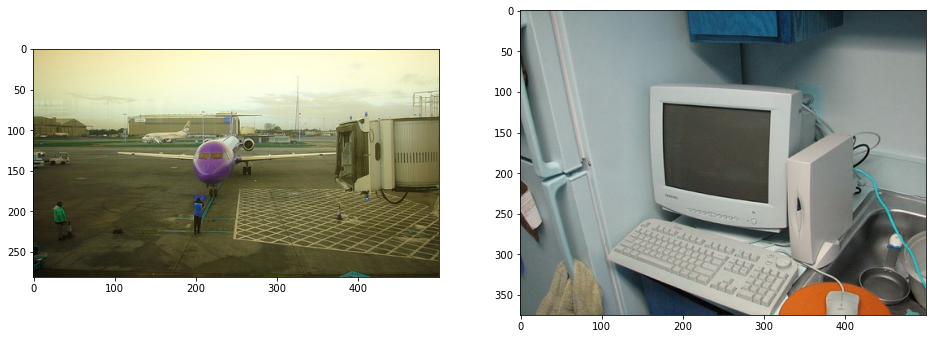

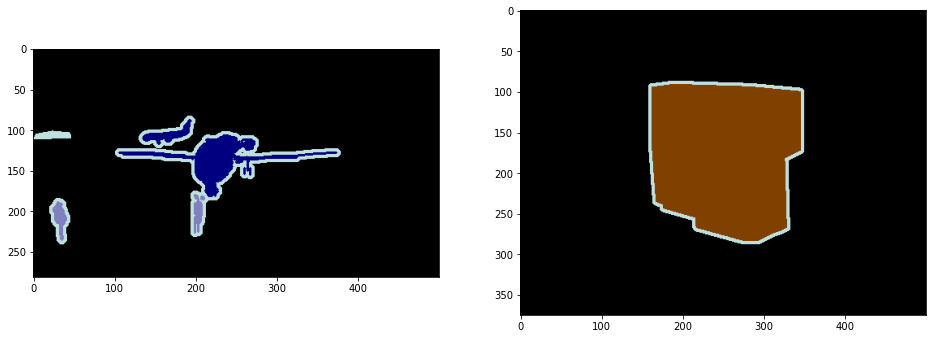

In [13]:
import matplotlib.pyplot as plt
import cv2
templates = [img_path_template, anno_path_template]
for template in templates:
    fig = plt.figure(figsize=(16,9))
    for i, line in enumerate(open(train_id_names)):
        if i<2:
            ax = fig.add_subplot(1,2,i+1)
            file_id = line.strip() # '\n'を消去
            print(file_id)
            img_path = template % file_id
            print(img_path)
            img=cv2.imread(img_path)
            ax.imshow(img)
plt.show()

In [33]:
def make_datapath_list(rootpath):
    '''
        学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。
        
    '''
    img_path_template = os.path.join(rootpath, 'JPEGImages', '%s.jpg')
    anno_path_template = os.path.join(rootpath, 'SegmentationClass', '%s.png')
    
    train_id_names = os.path.join(rootpath, 'ImageSets/Segmentation', 'train.txt')
    val_id_names = os.path.join(rootpath, 'ImageSets/Segmentation', 'val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = img_path_template % file_id
        anno_path = anno_path_template % file_id
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)        
    
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = img_path_template % file_id
        anno_path = anno_path_template % file_id
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)        
    
    return train_img_list, train_anno_list, val_img_list, val_anno_list

rootpath = './data/VOCdevkit/VOC2012'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


## Datasetの作成
訓練データではData Augmentationを行う。

`data_augmentation.py`を`import`して前処理クラスを使用する。実装されているクラスの内容は以下の通り。

- scale <br>画像の大きさを拡大縮小する。元の画像よりサイズが大きくなった場合は適当な位置で切り取る。小さくなった場合は黒色で埋める。
- RandomRotation <br>画像を回転させる。今回は-10~10度の範囲で回転させる。
- RandomMirror: <br>1/2の確率で左右を反転させる。
- Resize: <br>指定した画像サイズに変換する。
- Normalize_Tensor<br>画像データをPyTorchテンソル型に変換し、さらに色情報の標準化を行う。

In [16]:
!ls

3-2_DataLoader.ipynb		     data
3-3-6_NetworkModel.ipynb	     Implementation3.ipynb
3-7_PSPNet_training.ipynb	     make_folders_and_data_downloads.ipynb
3-8_PSPNet_inference_appendix.ipynb  utils
3-8_PSPNet_inference.ipynb	     weights
core.r1i0n5.44133


In [47]:
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor

class DataTransform():
    '''
    画像とアノテーションの前処理クラス。
    画像データをテンソルに変換し、画像サイズを変更する。
    訓練時にはdata augmentationを行う。
    
    Attributes
    -------------
    input_size: int
        リサイズ先の画像の大きさ
    color_mean: (R, G, B)
        色チャネルの平均値
    color_std: (R, G, B)
        色チャネルの標準偏差
    '''
    
    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),
                RandomRotation(angle=[-10,10]),
                RandomMirror(),
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ]),
            'val': Compose([
                Resize(input_size),
                Normalize_Tensor(color_mean, color_std)
            ])
        }
    
    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](img, anno_class_img)

In [48]:
import torch.utils.data as data
from PIL import Image

# Datasetクラスの作成 画像ファイルはopencvではなく第1章と同様にPillowを使用する
class VOCDataset(data.Dataset):
    
    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)
    
    def __getitem__(self, index):
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)
        
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)
        
        img, class_anno_img = self.transform(self.phase, img, anno_class_img)
        
        return img, anno_class_img

In [ ]:
!ls

3-2_DataLoader.ipynb		     data
3-3-6_NetworkModel.ipynb	     Implementation3.ipynb
3-7_PSPNet_training.ipynb	     make_folders_and_data_downloads.ipynb
3-8_PSPNet_inference_appendix.ipynb  utils
3-8_PSPNet_inference.ipynb	     weights
core.r1i0n5.44133


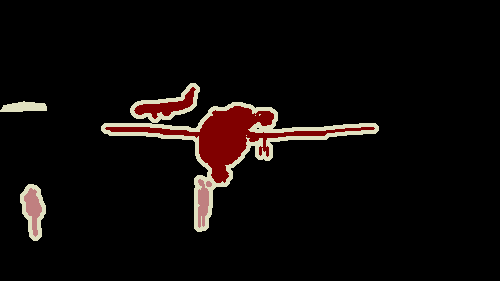

In [55]:
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
input_size = 475

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform=DataTransform(input_size, color_mean, color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, 'val', DataTransform(input_size, color_mean, color_std))
train_dataset.__getitem__(0)[1]

## DataLoaderの作成
今回はアノテーションのデータサイズがデータごとに変化しないのでPyTorchの標準の`DataLoader`を使用することができる\

In [30]:
batch_size=8

train_data_loader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_data_loader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_data_loader, 'val': val_data_loader}

batch_iterator = iter(dataloaders_dict['train'])
images, anno_class_imgs = next(batch_iterator)
print(next(batch_iterator))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.PngImagePlugin.PngImageFile'>

In [ ]:
import numpy as np